# 1. 라이브러리 불러오기 

In [1]:
# 데이터 처리 라이브러리
import os
import os.path as pth
from tqdm import tqdm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

# Tensorflow 관련 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten, Activation, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[1],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7300)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
print(tf.__version__)

2.3.0


# 2. 데이터 불러오기 

## 2-1. Labeling 데이터프레임 불러오기 

In [3]:
# 학습 데이터 준비 
path = "./data/landmark"  
label_df = pd.read_csv(path + '/category.csv') # 각 랜드마크별 label
label_dict = dict(label_df[['landmark_name', 'landmark_id']].values)
label_dict_reverse = dict(label_df.values)

## 2-2. Train Data 경로 불러오기

In [5]:
## Train 파일(JPG)명과 label 정보를 담은 데이터 프레임 생성
train_dirs = path + '/train'
files = []
categories=[]
for img_dir in os.listdir(train_dirs):
    img_dir_list = train_dirs + '/' + img_dir
    
    for filename in os.listdir(img_dir_list):
        file_dir = img_dir + '/' + filename
        files.append(file_dir)
        categories.append(label_dict[img_dir])
            
train_data=pd.DataFrame(
                    {"file":files,
                    "label":categories}
                )    

label_dict[img_dir]

310

## 2-3. Test Data 경로 불러오기

In [6]:
# test 데이터 안 '6' 폴더에 있는 체크포인트 오류 데이터 제거 후 실행
test_dirs = path + '/test'
files = []
ids=[]
for img_cat in os.listdir(test_dirs):
    id_dir = test_dirs + '/' + img_cat
    for filename in os.listdir(id_dir):
        files.append(id_dir + '/' +filename)
        ids.append(filename.split('.JPG')[0])
                           
test_data = pd.DataFrame(
                    {"file":files,
                    "id":ids}
                )    

test_data

,file,id
0,./data/landmark/test/0/0hmnf5orki.JPG,0hmnf5orki
1,./data/landmark/test/0/0bgj9co0zl.JPG,0bgj9co0zl
2,./data/landmark/test/0/03123sl42g.JPG,03123sl42g
3,./data/landmark/test/0/0vwaki2su2.JPG,0vwaki2su2
4,./data/landmark/test/0/09jgq862fk.JPG,09jgq862fk
...,...,...
37959,./data/landmark/test/h/hf700dgjt3.JPG,hf700dgjt3
37960,./data/landmark/test/h/hf5vrn6vdx.JPG,hf5vrn6vdx
37961,./data/landmark/test/h/hr5xdtptl2.JPG,hr5xdtptl2
37962,./data/landmark/test/h/hj455fxmjr.JPG,hj455fxmjr


# 3. TFRecord 데이터 처리 

## 3-1. TFRecord 압축파일 생성 

In [35]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

In [36]:
def to_tfrecords(id_list, randmark_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, randmark_id in tqdm(zip(id_list, randmark_id_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(train_dirs, id_)
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'randmark_id': _int64_feature(randmark_id),
                'id': _bytes_feature(id_.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [37]:
with tf.device('/device:GPU:1'):
    train_ids, val_ids, train_landmark_ids, val_landmark_ids = train_test_split(train_data['file'], train_data['label'], test_size=0.2, random_state=42, shuffle=True,
                                                                                stratify=train_data['label'])

    to_tfrecords(train_ids, train_landmark_ids, pth.join(path, 'tf_record_train'))
    to_tfrecords(val_ids, val_landmark_ids, pth.join(path, 'tf_record_valid'))

  0%|          | 12/70481 [00:00<09:58, 117.81it/s]

Start converting


  0%|          | 9/17621 [00:00<03:21, 87.50it/s]

Start converting


100%|██████████| 17621/17621 [03:39<00:00, 80.31it/s]


In [38]:
def to_test_tfrecords(id_list, test_id_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, test_id in tqdm(zip(id_list, test_id_list), total=len(id_list), position=0, leave=True):
            image_path = id_
            _binary_image = tf.io.read_file(image_path)

            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'id': _bytes_feature(test_id.encode()),
            }))

            writer.write(string_set.SerializeToString())    

In [39]:
with tf.device('/device:GPU:1'):
    test_ids = test_data['id']
    to_test_tfrecords(test_data['file'],test_data['id'], pth.join(path, 'tf_record_test'))

  0%|          | 10/37964 [00:00<07:25, 85.24it/s]

Start converting


100%|██████████| 37964/37964 [07:51<00:00, 80.47it/s]


## 3-2. TFrecord 파일 TEST(불러오기, 시각화)

In [7]:
train_tfrecord_path = pth.join(path, 'tf_record_train.tfrecords')
valid_tfrecord_path = pth.join(path, 'tf_record_valid.tfrecords')

BUFFER_SIZE = 128
BATCH_SIZE = 16
NUM_CLASS = 1049

In [8]:
with tf.device('/device:GPU:0'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'randmark_id': tf.io.FixedLenFeature([], tf.int64),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }


    
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

def map_func(target_record):
    img = target_record['image_raw']
    label = target_record['randmark_id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def prep_func(image, label):
    result_image = image / 255
    result_image = tf.image.resize(result_image, (224,224))
    onehot_label = tf.one_hot(label, depth=NUM_CLASS)
    return result_image, onehot_label

with tf.device('/device:GPU:0'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [42]:
with tf.device('/device:GPU:1'):
    model = Sequential()

(16, 224, 224, 3) (16, 1049)
서울과학기술대학교


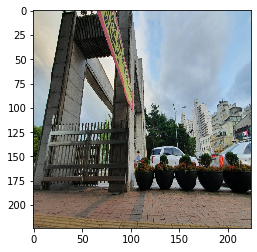

In [43]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)

    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict_reverse[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    # plt.title('{}'.format(category_dict[target_class]))
    plt.show()

    break

(16, 224, 224, 3) (16, 1049)
동구릉원릉


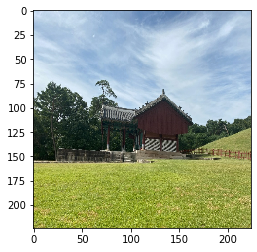

In [44]:
for batch_x, batch_y in valid_dataset:
    print(batch_x.shape, batch_y.shape)

    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict_reverse[target_class])
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    # plt.title('{}'.format(category_dict[target_class]))
    plt.show()

    break

In [9]:
test_tfrecord_path = pth.join(path, 'tf_record_test.tfrecords')

with tf.device('/device:GPU:0'):
    test_image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    
def test_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, test_image_feature_description)

def test_map_func(target_record):
    img = target_record['image_raw']
    label = target_record['id']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.dtypes.cast(img, tf.float32)
    return img, label

def test_prep_func(image, label):
    result_image = image / 255.
   
    return result_image, label
    

with tf.device('/device:GPU:0'):    
    test_dataset = tf.data.TFRecordDataset(test_tfrecord_path, compression_type='GZIP')
    test_dataset = test_dataset.map(test_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.map(test_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.shuffle(BUFFER_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.map(test_prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    

    

(16, 540, 960, 3) (16,)
tf.Tensor(
[b'0bur4yq6ka' b'0v1z53ttcd' b'0kffyey5fm' b'0m0ph092st' b'0jbtmz9xl2'
 b'0g5qg44fxu' b'04npm5lu0c' b'0dsxt0i6zo' b'0kxg4svdf5' b'0pnf3ntqcd'
 b'00zxdrqetr' b'0quj52f8p5' b'0hyy8fbwbo' b'0tdrwkb7lx' b'0e8ct9vlmk'
 b'0jithibtw0'], shape=(16,), dtype=string)


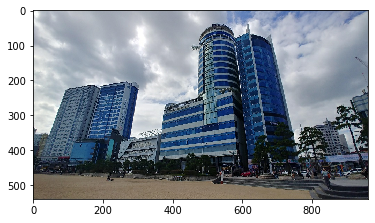

In [46]:
with tf.device('/device:GPU:1'):
    for batch_x, batch_y in test_dataset:
        print(batch_x.shape, batch_y.shape)
        print(batch_y)
        plt.figure()
        plt.imshow(batch_x[0].numpy())
        # plt.title('{}'.format(category_dict[target_class]))
        plt.show()

        break

# 4. 모델링 

## 4-1. Base CNN 

In [ ]:
with tf.device('/device:GPU:1'):
    model = Sequential()

    model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(270, 480, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1049, activation='softmax')) 

    model.summary()

In [ ]:
with tf.device('/device:GPU:1'):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:1'):
    history = model.fit(dataset,
            epochs=50,  
            validation_data=valid_dataset,

    #     callbacks = callbacks,
    )

In [9]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation , AveragePooling2D , Input ,Dropout
from tensorflow.keras.layers import Dense,  MaxPooling2D, Add, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import models, layers

In [10]:
print(dataset)
print(valid_dataset)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1049)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1049)), types: (tf.float32, tf.float32)>


In [16]:
from tensorflow.keras import models
from tensorflow.python.keras.applications.efficientnet import *

efficientnet = EfficientNetB0(weights ='imagenet', include_top = False, 
                              input_shape = (224, 224, 3), classifier_activation='softmax')

earlystop = EarlyStopping(patience=5)
learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=1e-7,
                        verbose=1)

model_check = ModelCheckpoint( #에포크마다 현재 가중치를 저장    
        filepath="landmark_efficientnetb0.h5", #모델 파일 경로
        monitor='val_loss',  # val_loss 가 좋아지지 않으면 모델 파일을 덮어쓰지 않음.
        save_best_only=True)

print(efficientnet.summary())    
# print(#################################################################################)   

callbacks = [earlystop, learning_rate_reduction, model_check]

for layer in efficientnet.layers:
    layer.trainable = False
 
with tf.device('/device:GPU:0'):  
    model = models.Sequential()
    model.add(efficientnet)
    model.add(layers.Flatten())
    model.add(Dense(258, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1049, activation='softmax')) 
    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_____________________________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 258)               16182018  
_________________________________________________________________
batch_normalization_2 (Batch (None, 258)               1032      
_________________________________________________________________
dropout_2 (Dropout)          (None, 258)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1049)              271691    
Total params: 20,504,312
Trainable params: 16,454,225
Non-trainable params: 4,050,087
__________________________________

In [ ]:
    history = model.fit(dataset,
                        batch_size=80,
                        epochs=10,
                        validation_data=valid_dataset,
                        callbacks = callbacks)

Epoch 1/10
4406/4406 [==============================] - 441s 100ms/step - loss: 7.0312 - accuracy: 9.7899e-04 - val_loss: 6.9575 - val_accuracy: 9.6476e-04
Epoch 2/10
4406/4406 [==============================] - 439s 100ms/step - loss: 6.9560 - accuracy: 0.0013 - val_loss: 6.9623 - val_accuracy: 9.0801e-04
Epoch 3/10
4406/4406 [==============================] - 438s 99ms/step - loss: 6.9449 - accuracy: 0.0017 - val_loss: 6.9684 - val_accuracy: 0.0010
Epoch 4/10
3978/4406 [==========================>...] - ETA: 35s - loss: 6.9406 - accuracy: 0.0016

In [21]:
def doesDataSetContainsEnoughDataForBatch(dataset, batch_size):
    return len(list(dataset.take(batch_size).as_numpy_iterator())) == batch_size
  
def doesDataSetFileContainsEnoughDataForBatch(sampleFileName="", batch_size=100):
    dataset = tf.data.TFRecordDataset(sampleFileName)
    return doesDataSetContainsEnoughDataForBatch(dataset, batch_size=batch_size)

if __name__ == '__main__':
  dataSetFileName=dataset
  if not doesDataSetFileContainsEnoughDataForBatch(dataSetFileName,batch_size=100):
    raise Exception(f"Data set file {dataSetFileName} doesn't contain enough data")
   
  # Now open the data set a second time knowing you have enough data 
  # and use it ....

trainDataset = tf.data.TFRecordDataset(dataSetFileName)

    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

TypeError: `filenames` must be a `tf.data.Dataset` of `tf.string` elements.